In [23]:
import glob
import pandas as pd
from IPython.display import clear_output
import matplotlib.pyplot as plt
import numpy as np
import datetime
from scipy.stats import pearsonr

In [2]:

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0))
    return (cumsum[N:] - cumsum[:-N]) / N

In [3]:
def getSentimentTS(city, fileList=None):
    if(fileList is None):
        fileList = sorted(glob.glob(f"./Datasets/cities-sentiment/{city}/*"))
    sentimentList = []
    for idx, file in enumerate(fileList):
        clear_output(wait=True)
#         print(f"{idx}/{len(fileList)}")
        df = pd.read_csv(file)
        scores = df[["negative", "positive", "neutral"]]
        sentimentCount = dict(pd.DataFrame(scores.idxmax(axis=1)).groupby(0).size())
        sentimentList.append(sentimentCount)
    qf = pd.DataFrame(sentimentList)
    qf["sentimentIndex"] = (qf["positive"]*1)+(-1*qf["negative"])
    qf["sentimentRatio"] = qf["positive"]/qf["negative"]
    qf["total"] = qf["positive"]+qf["negative"]+qf["neutral"]
    rm = running_mean(list(qf["sentimentRatio"]), 30)
    return rm

In [7]:
colors = {
    "Bangalore": "red",
    "Chennai": "yellow",
    "Kolkata": "purple",
    "Hyderabad": "orange",
    "Delhi": "blue",
    "Mumbai": "skyblue"
    
}

In [8]:
citySent = {}
for city in cityNames:
    citySent[city] = getSentimentTS(city)

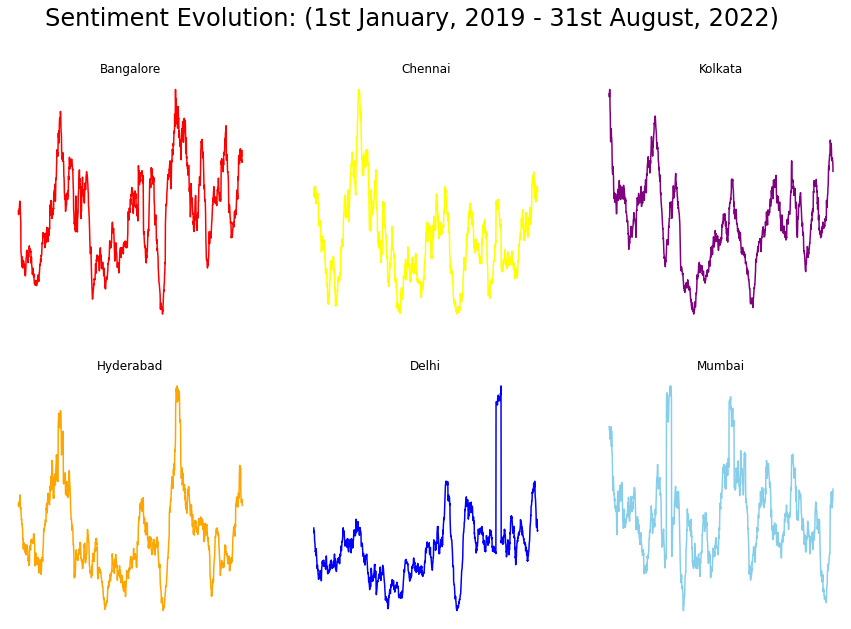

In [26]:

idx = 1
plt.figure(figsize=(15, 10))
plt.suptitle("Sentiment Evolution: (1st January, 2019 - 31st August, 2022)", fontsize=24)
for city in cityNames:
    plt.subplot(2, 3, idx)
    plt.title(f"{city}")
    plt.axis("off")
    plt.plot(citySent[city], color=colors[city])
    idx+=1
plt.plot()
plt.savefig("./viz/sentiment.jpg")

In [9]:
def getPrecovid(city):
    return getSentimentTS(city, fileList=sorted(glob.glob(f"./Datasets/cities-sentiment/{city}/*"))[:365+27])

In [10]:
def getPostcovid(city):
    return getSentimentTS(city, fileList=sorted(glob.glob(f"./Datasets/cities-sentiment/{city}/*"))[365+27:])

In [11]:
cityNames = ["Bangalore", "Chennai", "Kolkata", "Hyderabad", "Delhi", "Mumbai"]


In [12]:
precovid = {}
postcovid = {}

for city in cityNames:
    precovid[city] = getPrecovid(city)
    postcovid[city] = getPostcovid(city)

In [21]:
def getCorrMat(myDict):
    mat = []
    for out_city in myDict.keys():
        row = []
        for in_city in myDict.keys():
            corr, _ = pearsonr(myDict[out_city], myDict[in_city])
            row.append(float(corr))
        mat.append(row)
    return np.array(mat)

In [72]:
preCorr = getCorrMat(precovid)
postCorr = getCorrMat(postcovid)

In [17]:
mat = np.array(mat)

In [17]:
def createHeatMap(mat, names):
    plt.figure(figsize=(10, 10))
    plt.imshow(np.matrix(mat))
    plt.xticks(np.arange(len(names)), names, rotation=45)
    plt.yticks(np.arange(len(names)), names)
    plt.colorbar()
    for i in range(mat.shape[0]):
        for j in range(mat.shape[1]):
            plt.text(i, j, round(mat[i][j], 2), ha="center", va="center", color="w")

In [25]:
cityCorr = getCorrMat(citySent)

In [31]:
from geopy import geocoders  

In [32]:
gn = geocoders.GeoNames()

gn.geocode("Cleveland, OH 44106")
# (u'Cleveland, OH, US', (41.4994954, -81.6954088))

# >>> gn.geocode("Cleveland, OH", exactly_one=False)[0]
# (u'Cleveland, OH, US', (41.4994954, -81.6954088))

TypeError: __init__() missing 1 required positional argument: 'username'

In [39]:
from geopy.geocoders import Nominatim
geolocator = Nominatim(user_agent='myapplication')
location = geolocator.geocode("Chennai")

In [43]:
cods = {}

In [44]:
for city in cityNames:
    myGeo = geolocator.geocode(city)
    cods[city] = (myGeo.latitude, myGeo.longitude)

In [55]:
dist = []

In [47]:
geopy.distance.geodesic(coords_1, coords_2).km

279.35290160430094

In [56]:
for out_city in cityNames:
    dist_row = []
    for in_city in cityNames:
        dist_row.append(geopy.distance.geodesic(cods[out_city], cods[in_city]).km)
    dist.append(dist_row)

In [61]:
dist_im = np.array(dist)

In [63]:
cityCorr.shape

(6, 6)

In [65]:
dist_im.flatten()

array([   0.        ,  290.95424007, 1558.46649013,  494.27983377,
       1735.94400681,  842.55303787,  290.95424007,    0.        ,
       1355.30217185,  511.05511751, 1752.38776304, 1031.89255431,
       1558.46649013, 1355.30217185,    0.        , 1184.54330128,
       1305.10346721, 1656.73411301,  494.27983377,  511.05511751,
       1184.54330128,    0.        , 1256.99285663,  621.6377223 ,
       1735.94400681, 1752.38776304, 1305.10346721, 1256.99285663,
          0.        , 1148.59380984,  842.55303787, 1031.89255431,
       1656.73411301,  621.6377223 , 1148.59380984,    0.        ])

In [66]:
dist_corr, _ = pearsonr(cityCorr.flatten(), dist_im.flatten())

In [67]:
dist_corr

-0.6098357209607443

In [82]:
pre_dist_corr, _ = pearsonr(preCorr.flatten(), dist_im.flatten())

In [81]:
post_dist_corr, _ = pearsonr(postCorr.flatten(), dist_im.flatten())

In [83]:
pre_dist_corr

-0.392023071169046

In [84]:
post_dist_corr

-0.5640765596161261

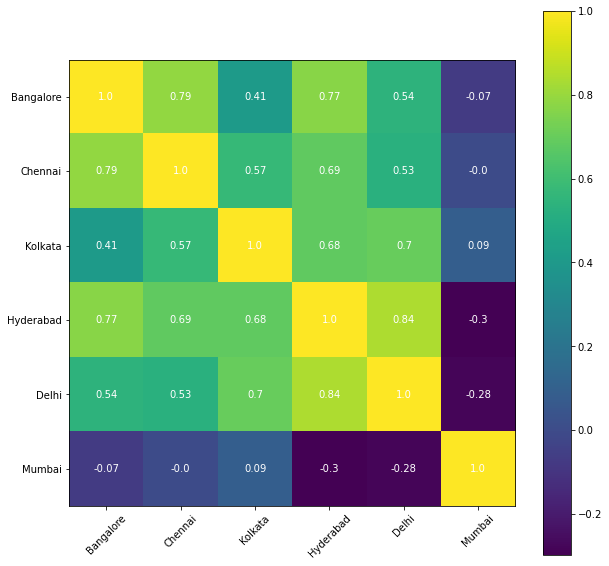

In [74]:
createHeatMap(preCorr, list(precovid.keys()))
plt.savefig("./viz/precovid-corr.jpg", dpi=250)

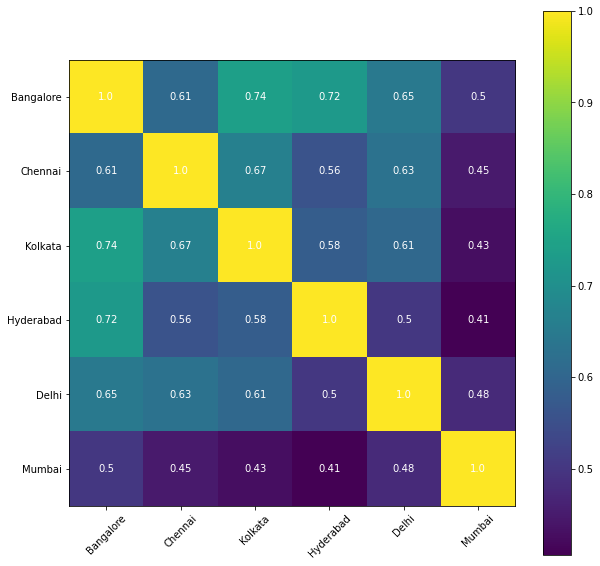

In [75]:
createHeatMap(postCorr, list(postcovid.keys()))
plt.savefig("./viz/postcovid-corr.jpg", dpi=250)

In [77]:
print(f"Precovid Stats:\nMean: {round(np.mean(preCorr), 4)}; Std: {round(np.std(preCorr), 4)}")
print(f"Postcovid Stats:\nMean: {round(np.mean(postCorr), 4)}; Std: {round(np.std(postCorr), 4)}")

Precovid Stats:
Mean: 0.4977; Std: 0.4175
Postcovid Stats:
Mean: 0.6404; Std: 0.1856
